Begun 12/12/2024

Analyzing results from running 264 test maps after correcting an issue with not accounting for the reduction in effective number of modes due to inverse variance weighting - because the errorbars are now larger, the optimal cuts may be different and need to be reassessed. In this data set, the residual sum variable has been corrected so I don't need to recompute it here.

Results are in angle_calc_1733966436

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1733966436/angle_calc_1733966436_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [6]:
ivar_sums = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = np.abs(spectra_dict[maps[i]]['residual_sum'])
    all_errbars[i] = np.abs(spectra_dict[maps[i]]['meas_errbar'])
    
print(np.where(residual_sums==9999)[0])   # Maps cut by galaxy mask
print(np.where(all_errbars<0.5)[0])       # Maps where curve_fit failed

[ 43  44  45 229 230 240 241 242]
[]


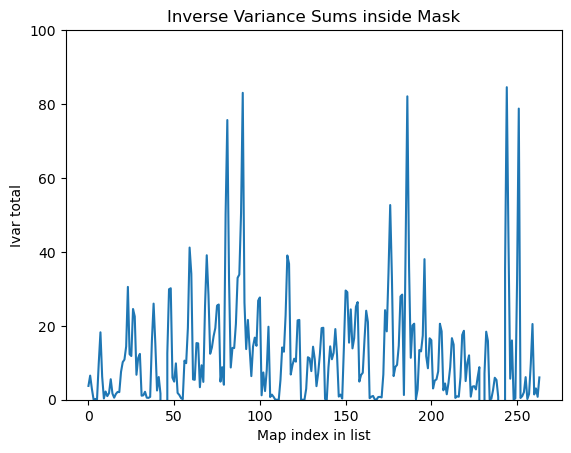

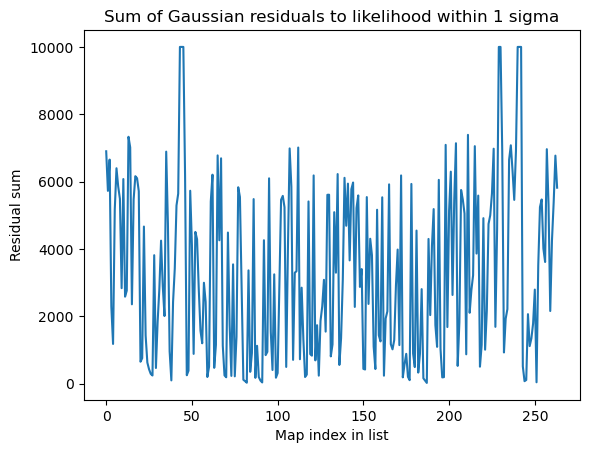

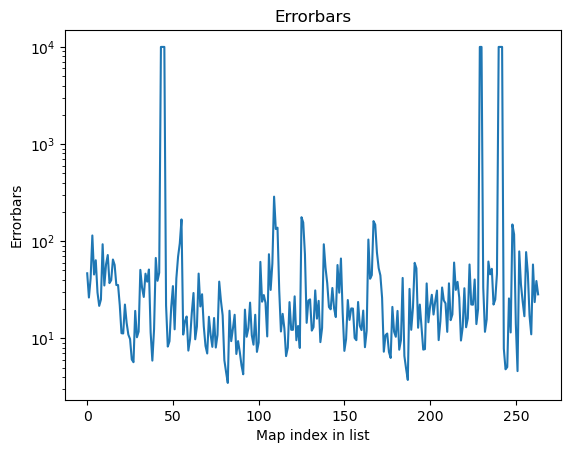

In [27]:
plt.plot(ivar_sums)
plt.ylim(0,100)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.plot(residual_sums)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.semilogy(all_errbars)
plt.title("Errorbars")
plt.ylabel("Errorbars")
plt.xlabel("Map index in list")
plt.show()
plt.close()

In [50]:
maps[72]

'depth1_1514113590_pa5_f150_map.fits'

In [24]:
# List of indices from looking at likelihoods by eye
very_good = [24,25,26,27,29,38,47,48,59,60,63,69,70,73,75,80,81,82,84,85,87,89,90,91,97,99,100,116,117,124,
             150,151,157,162,173,174,175,176,177,180,182,185,186,187,196,197,218,243,244,245,251]
good = [20,21,23,30,37,51,56,57,58,64,68,76,83,88,93,94,96,105,113,114,115,119,120,122,123,128,131,132,136,137,
        153,156,159,160,163,179,183,193,195,199,205,206,210,212,213,219,221,222,227,232,233,247]
borderline = [6,13,14,16,22,28,39,66,67,72,74,79,92,98,107,121,142,145,149,152,154,155,158,189,190,198,202,
              204,211,215,231,250,259]
bad = [0,1,2,3,4,5,7,8,9,10,11,12,15,17,18,19,31,32,33,34,35,36,40,41,42,46,49,50,52,53,54,55,61,62,65,71,77,78,
       86,95,101,102,103,104,106,108,109,110,111,112,118,125,126,127,129,130,133,134,135,138,139,140,141,143,
       144,146,147,148,161,164,165,166,167,168,169,170,171,172,178,181,184,188,191,192,194,200,201,203,207,208,
       209,214,216,217,220,223,224,225,226,228,234,235,236,237,238,239,246,248,249,252,253,254,255,256,257,258,
       260,261,262,263]
cut = [43,44,45,229,230,240,241,242]
bad_fits = [] # all bad ones because curve_fit fails to fit
print(len(very_good), len(good), len(borderline), len(bad), len(cut), len(bad_fits))
all_good = np.sort(very_good+good)
all_bad = np.sort(bad+cut)
all_not_cut = very_good+good+borderline+bad

51 52 33 120 8 0


In [42]:
print(np.where(ivar_sums==0)[0])
print(spectra_dict[maps[124]]['w2_ref'])

[109 124 125 126 139 168 248]
3.648613188462022e-06


409
20.550000000000008
0.5048543689320388
0.9393939393939394


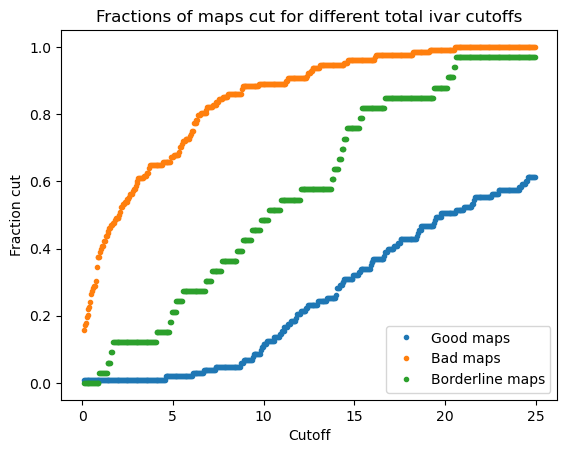

In [29]:
# Iterating over different ivar cutoffs to examine fraction that is cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(0.1,25.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    #print(outlier_indices_ivar_sums)
    num_outlier = len(outlier_indices_ivar_sums)
    for i in range(num_outlier):
        if outlier_indices_ivar_sums[i] in all_good: in_good += 1
        elif outlier_indices_ivar_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_ivar_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print(good_fractions_cut[index_all_bad_cut])
print(border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

459
705
Fraction of good maps cut at index with all bad cut:  0.47572815533980584
Fraction borderline cut at index with all bad cut:  1.0


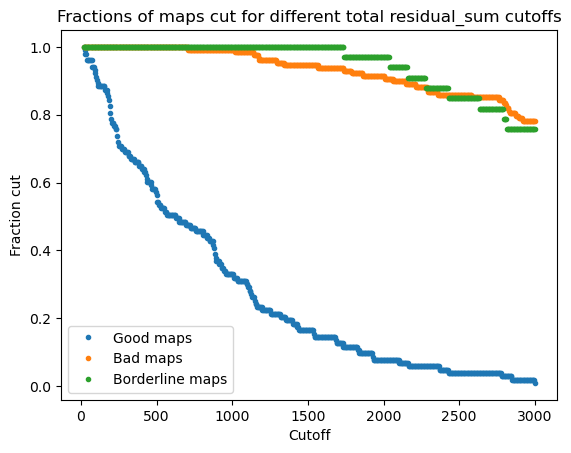

In [30]:
# Iterating over different cutoffs of residual_sums to examine fraction that is cut
# List of indices from looking at likelihoods by eye
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(3000,15,-5) # Want to cut big values
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_residual_sums)
    num_outlier = len(outlier_indices_residual_sums)
    for i in range(num_outlier):
        if outlier_indices_residual_sums[i] in all_good: in_good += 1
        elif outlier_indices_residual_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_residual_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual_sum cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

188
2060
Fraction of good maps cut at index with all bad cut:  0.08737864077669903
Fraction borderline cut at index with all bad cut:  0.9393939393939394


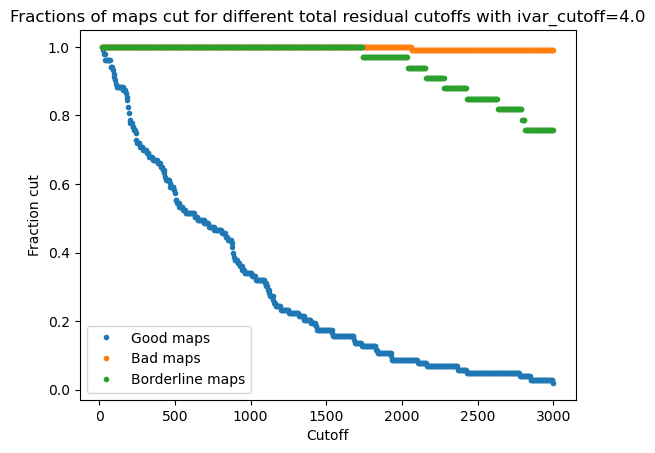

In [49]:
# Testing fixing the ivar cut and then sweeping out residual cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
ivar_cutoff = 4.0
cutoffs = np.arange(3000,15,-5)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < ivar_cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual cutoffs with ivar_cutoff="+str(ivar_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()